# Visualization: Hits, Charges, Timing and Energy

import packages

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import stats
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs
%matplotlib inline

In [96]:
#load in h5 file and indices files
h5_filepath = "/home/mattStubbs/watchmal/NeutronGNN/data/h5_files/iwcd_mpmt_shorttank_neutrongnn_50files.h5"
train_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/train_indicies_50files.txt"
val_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/validation_indicies_50files.txt"
test_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/test_indicies_50files.txt"

To access any part of the h5 dataset, <br> 
1) read the h5 file, 2) create a memory mapping to it <br>

looking into the h5 file... <br> 
x_data = [charge, time, pmt_position_x, pmt_position_y, pmt_position_z, pmt_direction_x, pmt_direction_y, pmt_direction_z] <br>
'labels' == particle id, ... , 
'event_data' == x_data

In [147]:
with h5py.File(h5_filepath, 'r') as file:
    print(list(file.keys()))
    h5_event_data = file['event_data']
    h5_nhits = file['nhits']
    h5_labels = file['labels']
    labels = np.array(h5_labels)
    
    event_data = np.memmap(h5_filepath, mode='r', shape=h5_event_data.shape,
                               offset=h5_event_data.id.get_offset(),
                               dtype=h5_event_data.dtype)
    print("Event memory data shape: " + str(event_mem_data.shape))
    print("{} events. Up to {} hits per event. {} features per hit per event".format(h5_event_data.shape[0], h5_event_data.shape[1], h5_event_data.shape[2]))
    nhits = np.array(h5_nhits)
    positions0 = file['positions']   #initial positions of simulated particles
    positions0 = np.array(positions0)
    h5_energy = file["energies"]

['angles', 'energies', 'event_data', 'event_ids', 'labels', 'nhits', 'positions', 'root_files']
Event memory data shape: (43961, 300, 8)
43961 events. Up to 300 hits per event. 8 features per hit per event


In [80]:
#sample a few events and aggregate hit totals
for x in range(0, 50000, 10000):
    print("event: {}, label: {}, nhits: {}".format(x, labels[x], nhits[x]))

event: 0, label: 1, nhits: 66
event: 10000, label: 1, nhits: 72
event: 20000, label: 1, nhits: 44
event: 30000, label: 1, nhits: 10
event: 40000, label: 1, nhits: 50


In [59]:
def load_indicies(indicies_file):
    with open(indicies_file, 'r') as f:
        lines = f.readlines()
        # indicies = [int(l.strip()) for l in lines if not l.isspace()]
        indicies = [int(l.strip()) for l in lines]
    return indicies

Verify the number of hits per event

In [60]:
non_zero = [np.count_nonzero(event_mem_data[i,:,0]) for i in range(0, event_mem_data.shape[0])]
non_zero  = np.array(non_zero)
# nhits should be equal to non_zero
assert nhits.all() == non_zero.all()

__Visualize Hits Throughout the Short Tank__

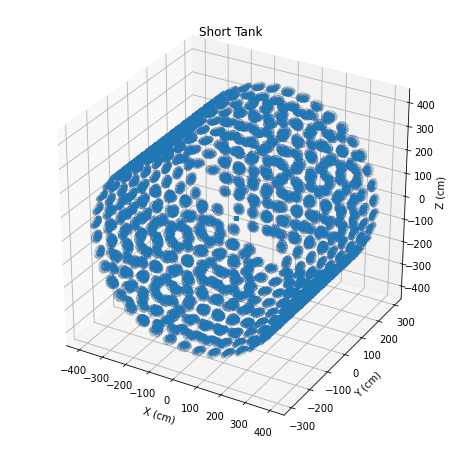

In [68]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=event_mem_data[:, :, 2],
    ys=event_mem_data[:, :, 3],
    zs=event_mem_data[:, :, 4],
    alpha = 0.007,
)
#ax.set_title('Hit Locations of 16,000 events')
ax.set_title('Short Tank')
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')

plt.show()

The hits occur on photomultiplier tubes (PMTs) through the circumference of the cylindrical tank. <br>
The vertices (location of start of event) are distributed throughout the tank. First, let us separate the events by particle type:

In [74]:
# initial positions
npPositions0 = [positions0[i].flatten() for i in range(len(positions0))]

In [76]:
npNeutron0 = []
npElectron0 = []
for x in range(event_data.shape[0]):
    if labels[x]==0:
        npNeutron0.append(positions0[x])
    elif labels[x]==1:
        npElectron0.append(positions0[x])
npNeutron0 = np.array(npNeutron0)
npElectron0 = np.array(npElectron0)

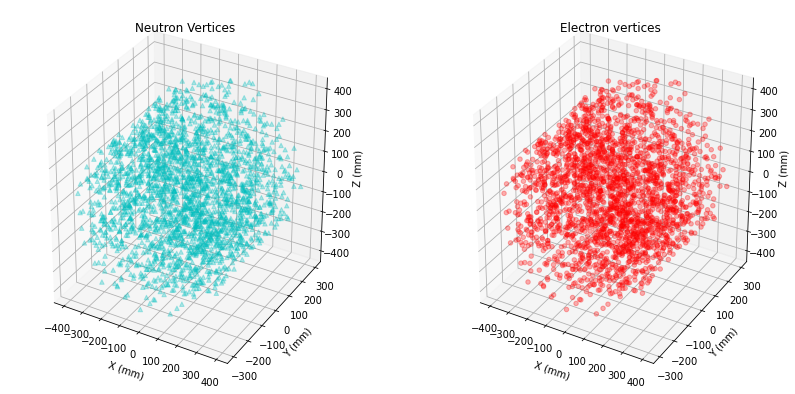

In [77]:
fig = plt.figure(figsize=(14, 7))
#ax = fig.add_subplot(111, projection='3d')
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(
    xs=npNeutron0[:, :, 0],
    ys=npNeutron0[:, :, 1],
    zs=npNeutron0[:, :, 2],
    c='c', marker='^', alpha = 0.3
)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(
    xs=npNeutron0[:, :, 0],
    ys=npNeutron0[:, :, 1],
    zs=npNeutron0[:, :, 2],
    c='r', marker='o', alpha = 0.3
)


ax1.set_title('Neutron Vertices')
ax2.set_title('Electron vertices')
ax1.set_xlabel('X (mm)'); ax2.set_xlabel('X (mm)')
ax1.set_ylabel('Y (mm)'); ax2.set_ylabel('Y (mm)')
ax1.set_zlabel('Z (mm)'); ax2.set_zlabel('Z (mm)')
plt.show()

# Hits Ditribution

aggregate number of hits within an event

Text(0, 0.5, 'Counts/bin (normalized)')

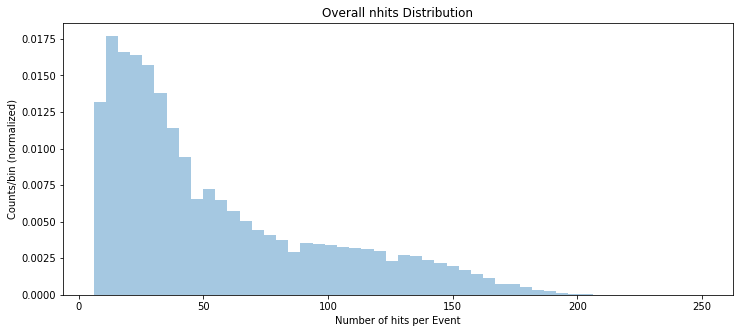

In [81]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(111) 
sns.distplot(nhits, rug = False, kde=False, axlabel ="Number of hits per Event", norm_hist=True)
plt.title("Overall nhits Distribution")
plt.ylabel("Counts/bin (normalized)")

In [82]:
print(np.unique(labels))

[0 1]


__Separate nhits array based on whether the event is electron or neutron__

get the index of the electron or neutron events. The way the files have been merged, they have not been shuffled yet - so there will be all events of one type, then all events of the next. <br>
label = 0 -> neutron <br>
label = 1 -> electron

In [107]:
neutron_hits = []
electron_hits = []
print(labels.shape)

for i in range(event_data.shape[0]):
    if labels[i] == 0:
        neutron_hits.append(nhits[i])
    elif labels[i] == 1:
        electron_hits.append(nhits[i])

#convert to numpy arrays
neutron_hits = np.array(neutron_hits)
electron_hits = np.array(electron_hits)
        
print('neutron events: {} \t e- events: {}'.format(neutron_hits.shape, electron_hits.shape))

(43961,)
neutron events: (20779,) 	 e- events: (23182,)


In [86]:
print(stats.describe(neutron_hits))
print(stats.describe(electron_hits))

DescribeResult(nobs=834171, minmax=(6, 182), mean=28.028594856450297, variance=237.6339678085872, skewness=0.8446019969047107, kurtosis=0.2998505492065986)
DescribeResult(nobs=925789, minmax=(6, 250), mean=79.36703179666209, variance=2082.832003436732, skewness=0.3018152057732568, kurtosis=-0.864101496682312)


Statistics on the neutron and electron event hit numbers. Visualize difference between hit distributions of neutron and electron events. Fit kernel density estimate.

Text(0, 0.5, 'Counts/bin (normalized)')

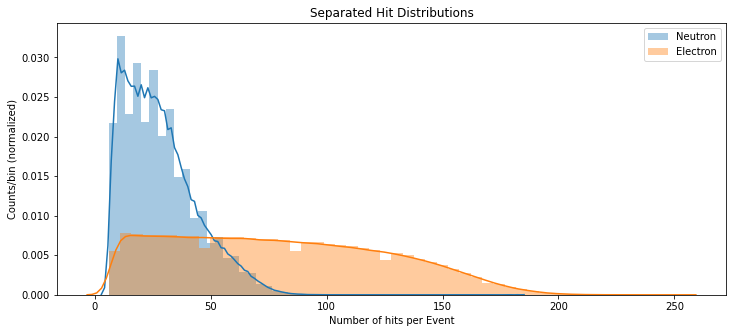

In [88]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(111) 
sns.distplot(neutron_hits, rug = False, axlabel ="Number of hits per Event", label = "Neutron")
sns.distplot(electron_hits, rug = False, label = "Electron")
plt.legend()
plt.title("Separated Hit Distributions")
plt.ylabel("Counts/bin (normalized)")
#plt.savefig("hit_separation.png", bbox_inches='tight') 

# Charge

aggregate charge within an event

In [100]:
with h5py.File(h5_filepath, 'r') as file:
    print(list(file.keys()))
    h5_labels = file['labels']
    labels = np.array(h5_labels)
    h5_event_data = file['event_data']
    event_data = np.memmap(h5_filepath, mode='r', shape=h5_event_data.shape,
                               offset=h5_event_data.id.get_offset(),
                               dtype=h5_event_data.dtype)
    print("Event memory data shape: " + str(event_mem_data.shape))
    
    h5_charges = event_mem_data[:, :, 0]
    print(h5_charges.shape)
    h5_charges = np.array(h5_charges)
    #nhits = np.array(h5_nhits)

['angles', 'energies', 'event_data', 'event_ids', 'labels', 'nhits', 'positions', 'root_files']
Event memory data shape: (43961, 300, 8)
(43961, 300)


sum charge within an event

In [101]:
q_sums = h5_charges.sum(axis = 1)
q_sums = np.array(q_sums)

overall distribution:

Text(0, 0.5, 'Counts/bin (normalized)')

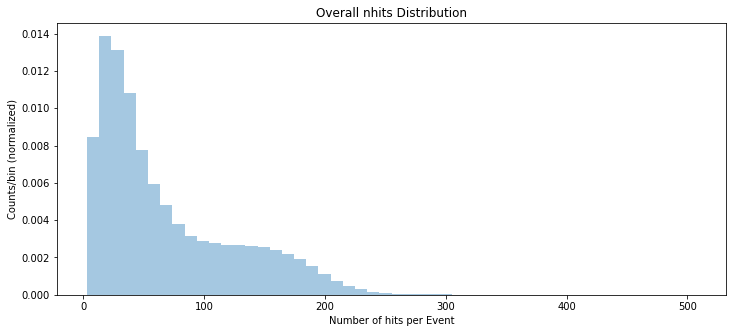

In [93]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(111) 
sns.distplot(q_sums, rug = False, kde=False, axlabel ="Number of hits per Event", norm_hist=True)
plt.title("Overall nhits Distribution")
plt.ylabel("Counts/bin (normalized)")

separate by particle type, analagous to aggregate hits

In [102]:
neutron_charge_sums = []
electron_charge_sums = []

for i in range(event_data.shape[0]):
    if labels[i] == 0:
        neutron_charge_sums.append(q_sums[i])
    elif labels[i] == 1:
        electron_charge_sums.append(q_sums[i])   

In [103]:
# few samples 
print(neutron_charge_sums[:15])
print(electron_charge_sums[:15])

[41.584465, 43.12234, 7.0457644, 22.84306, 12.510172, 61.502735, 29.011889, 23.144814, 11.292397, 22.060467, 19.665867, 24.311583, 25.689318, 25.410654, 30.432682]
[90.71265, 40.10595, 53.739975, 190.99295, 40.67142, 107.36137, 71.77139, 157.61174, 35.43709, 212.51834, 170.2475, 142.61873, 24.210955, 200.87871, 227.72697]


neutron charge stats ... 
DescribeResult(nobs=20779, minmax=(3.2661016, 208.25096), mean=32.881374, variance=352.38416, skewness=1.0349177122116089, kurtosis=1.6182548260233647)

electron charge stats ... 
DescribeResult(nobs=23182, minmax=(4.634709, 415.6129), mean=101.98235, variance=3498.439, skewness=0.34979233145713806, kurtosis=-0.5147333341032878)


Text(0, 0.5, 'Counts/bin (normalized)')

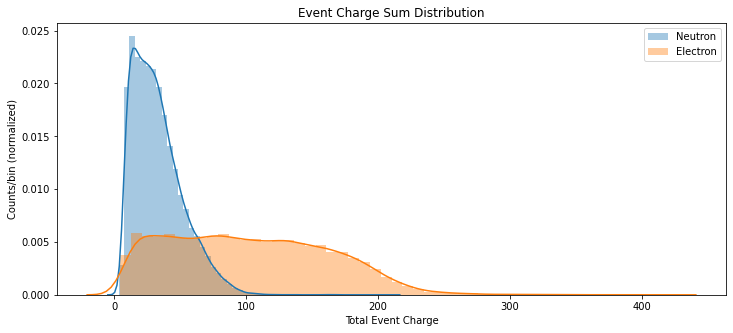

In [105]:
print("neutron charge stats ... \n" + str(stats.describe(neutron_charge_sums))), print("")
print("electron charge stats ... \n" + str(stats.describe(electron_charge_sums)))

fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111) 

ax = sns.distplot(neutron_charge_sums, rug = False, axlabel ="Total Event Charge", label = "Neutron")
ax = sns.distplot(electron_charge_sums, rug = False, label = "Electron")
plt.legend()
plt.title("Event Charge Sum Distribution")
plt.ylabel("Counts/bin (normalized)")
#plt.savefig("charge_separation.png", bbox_inches = 'tight', dpi=600) 

__2d charge/hits perspective__

plot charge/hits 2d jointplot with 7 major contours

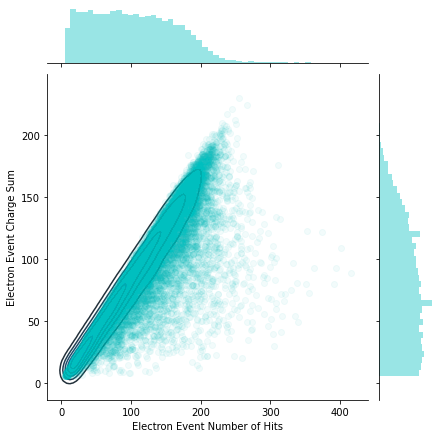

In [108]:
g = (sns.jointplot(electron_charge_sums, electron_hits,
                  color = 'c', height = 6, alpha = 0.05)
                  .plot_joint(sns.kdeplot, zorder=0, n_levels=6).set_axis_labels("Electron Event Number of Hits", "Electron Event Charge Sum"))

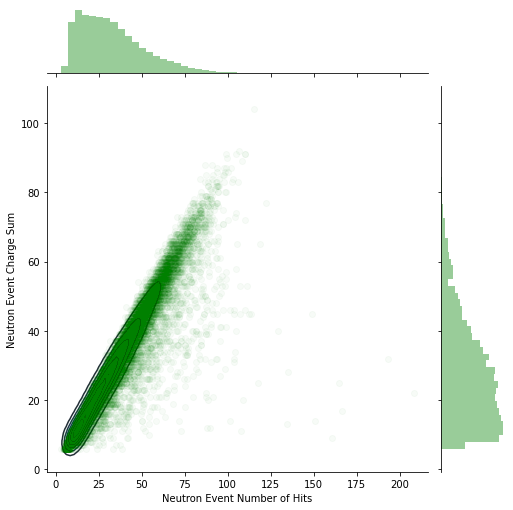

In [110]:
h = (sns.jointplot(neutron_charge_sums, neutron_hits,
                  color = 'g', height = 7, alpha = 0.03)
                  .plot_joint(sns.kdeplot, zorder=0, n_levels=6).set_axis_labels("Neutron Event Number of Hits", "Neutron Event Charge Sum"))

# Timing

In [115]:
neutron_times = []; neutron_indices = []
electron_times = []; electron_indices = []

for i in range(event_data.shape[0]):
    if labels[i] == 0:
        neutron_times.append(event_data[i, :, 1])
        neutron_indices.append(i)
    elif labels[i] == 1:
        electron_times.append(event_data[i, :, 1])   
        electron_indices.append(i)

In [116]:
neutron_times = np.array(neutron_times)
electron_times = np.array(electron_times)

print(neutron_times.shape)
print(electron_times.shape)

(20779, 300)
(23182, 300)


__average, min, max and range of event times__

In [121]:
neutron_timeRange = []; neutron_minTimes = []; neutron_maxTimes = []; neutron_meanTimes = []
e_timeRange = []; e_minTimes = []; e_maxTimes = []; e_meanTimes = []

for i in range(len(neutron_times)):
    neutron_timeRange.append(max(neutron_times[i, :nhits[neutron_indices[i]]]) - min(neutron_times[i, :nhits[neutron_indices[i]]]))
    neutron_minTimes.append(min(neutron_times[i, :nhits[neutron_indices[i]]]))
    neutron_maxTimes.append(max(neutron_times[i, :nhits[neutron_indices[i]]]))
    neutron_meanTimes.append(np.average(neutron_times[i, :nhits[neutron_indices[i]]]))
    
for i in range(len(electron_times)):
    e_timeRange.append(max(electron_times[i, :nhits[electron_indices[i]]]) - min(electron_times[i, :nhits[electron_indices[i]]]))
    e_minTimes.append(min(electron_times[i, :nhits[electron_indices[i]]]))
    e_maxTimes.append(max(electron_times[i, :nhits[electron_indices[i]]]))
    e_meanTimes.append(np.average(electron_times[i, :nhits[electron_indices[i]]]))

__mean times__

These mean times have a similar peak around 970-975ns, however the electron mean time variance is much more constrained. The variance of the neutron mean times is over 2x greater.

In [129]:
print("neutron mean times ... \n" + str(stats.describe(neutron_meanTimes))), print("")
print("electron mean times ... \n" + str(stats.describe(e_meanTimes)))

neutron mean times ... 
DescribeResult(nobs=20779, minmax=(859.2908, 1249.2548), mean=976.9038, variance=896.2424, skewness=1.6591020822525024, kurtosis=5.637940589607046)

electron mean times ... 
DescribeResult(nobs=23182, minmax=(876.4, 1214.3734), mean=971.3221, variance=299.34592, skewness=3.0106823444366455, kurtosis=22.019397388472267)


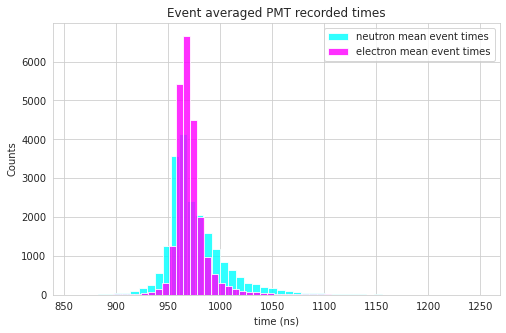

In [131]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(neutron_meanTimes, color = 'cyan', bins=50, alpha = 0.81, label = 'neutron mean event times')
plt.hist(e_meanTimes, color = 'magenta', bins=50, alpha = 0.81, label = 'electron mean event times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event averaged PMT recorded times")
plt.legend()

__event time of flight__

the time of flight distributions are quite similar here, although we do see more neutron events having a shorter time of flight. However, this metric (time of flight) is highly sensitive to dark noise PMT hits

In [132]:
print(stats.describe(neutron_timeRange))
print(stats.describe(e_timeRange))

DescribeResult(nobs=20779, minmax=(2.9003906, 1344.4004), mean=437.82275, variance=119462.75, skewness=0.38361209630966187, kurtosis=-1.0955524017686376)
DescribeResult(nobs=23182, minmax=(2.7000122, 1346.7), mean=439.76205, variance=114775.21, skewness=0.42899999022483826, kurtosis=-1.027859217154471)


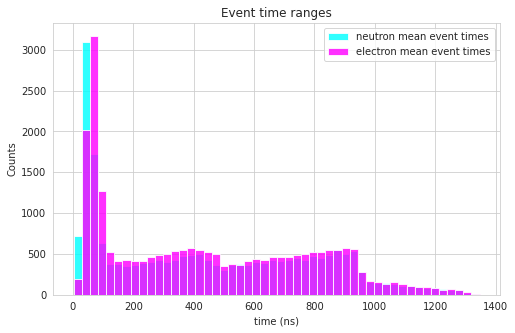

In [134]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(neutron_timeRange, color = 'cyan', bins=50, alpha = 0.81, label = 'neutron mean event times')
plt.hist(e_timeRange, color = 'magenta', bins=50, alpha = 0.81, label = 'electron mean event times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event time ranges")
plt.legend()

__min times__

Up until just after 900ns, we see a few hits from dark noise. After that, the neutron/electron distributions are similar although there is a greater number of neutron events starting at earlier times

In [135]:
print(stats.describe(neutron_minTimes))
print(stats.describe(e_minTimes))

DescribeResult(nobs=20779, minmax=(550.0, 953.7012), mean=874.80023, variance=14456.9, skewness=-1.430097222328186, kurtosis=0.5365452735872691)
DescribeResult(nobs=23182, minmax=(550.0, 953.9), mean=877.3345, variance=14541.178, skewness=-1.4284864664077759, kurtosis=0.5298854260933865)


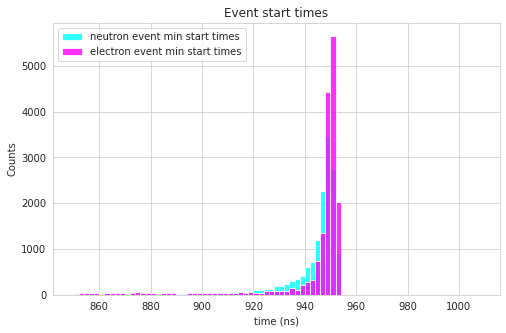

In [138]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(neutron_minTimes, color = 'cyan', bins=np.arange(850,1010, 2), alpha = 0.81, label = 'neutron event min start times')
plt.hist(e_minTimes, color = 'magenta', bins=np.arange(850,1010, 2), alpha = 0.81, label = 'electron event min start times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event start times")
plt.legend()

__max times__

In [139]:
print(stats.describe(neutron_maxTimes))
print(stats.describe(e_maxTimes))

DescribeResult(nobs=20779, minmax=(950.0, 1900.002), mean=1312.6229, variance=104512.14, skewness=0.3996196985244751, kurtosis=-1.4068991215765172)
DescribeResult(nobs=23182, minmax=(950.0, 1900.0), mean=1317.0966, variance=99762.99, skewness=0.4383508265018463, kurtosis=-1.3789801813780256)


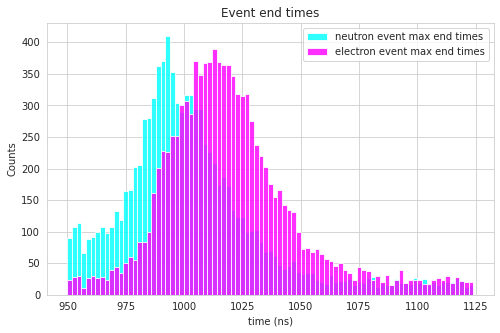

In [142]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(neutron_maxTimes, color = 'cyan', bins=np.arange(950,1125,2), alpha = 0.81, label = 'neutron event max end times')
plt.hist(e_maxTimes, color = 'magenta', bins=np.arange(950,1125,2), alpha = 0.81, label = 'electron event max end times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event end times")
plt.legend()

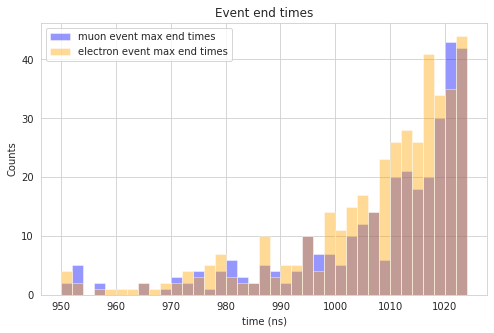

# Energy

In [57]:
#load in h5 file and indices files
h5_filepath = "/bigdisk/mattStubbs/data/h5_files/emu50.h5"
train_indices_file = "/bigdisk/mattStubbs/data/splits/train_indicies_50files_emu.txt"
val_indices_file = "/bigdisk/mattStubbs/data/splits/validation_indicies_50files_emu.txt"
test_indices_file = "/bigdisk/mattStubbs/data/splits/test_indicies_50files_emu.txt"

In [150]:
file = h5py.File(h5_filepath,'r')
print(file.keys())
h5_event_data = file["event_data"]
h5_labels = file["labels"]
h5_nhits = file["nhits"]
labels = np.array(h5_labels)
nhits = np.array(h5_nhits)
h5_energy = file["energies"]

event_data_offset = h5_event_data.id.get_offset()
event_data_dtype = h5_event_data.dtype   

event_data = np.memmap(h5_filepath, mode='r', 
                            shape=h5_event_data.shape,
                            offset=event_data_offset, 
                            dtype=event_data_dtype)

<KeysViewHDF5 ['angles', 'energies', 'event_data', 'event_ids', 'labels', 'nhits', 'positions', 'root_files']>


In [151]:
print(event_data.shape)

(43961, 300, 8)


In [152]:
h5_energy = np.array(h5_energy)
h5_energy = np.reshape(h5_energy, (len(h5_energy), -1))
h5_energy = h5_energy.flatten()

In [153]:
print(h5_energy.shape)

(43961,)


In [154]:
print(h5_energy[:10])

[ 9.703471   6.893087   6.392733  15.772576   4.0892606 10.898928
  7.5624266 15.9206085 14.884148  20.420986 ]


Events are either 0-20MeV for electron events (simulated energy distribution) and around 940.6MeV for neutron captures (de-excitation until minimum energy threshold for capture)

Text(0, 0.5, 'Counts/bin')

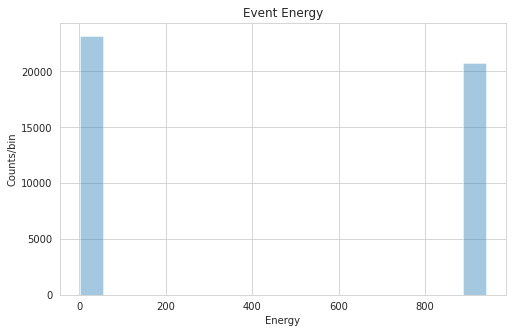

In [156]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 
sns.distplot(h5_energy, rug = False, kde=False, axlabel ="Energy", norm_hist=False)
plt.title("Event Energy")
plt.ylabel("Counts/bin")

In [161]:
neutron_energies = []
e_energies = []

for i, j in enumerate(h5_energy):
    if labels[i] == 0: #muon
        neutron_energies.append(j)
    elif labels[i] == 1:  #electron
        e_energies.append(j)

Text(0, 0.5, 'Counts/bin')

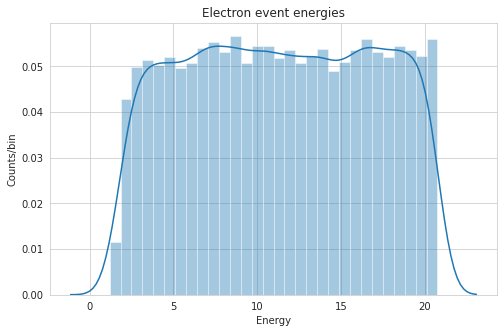

In [158]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 
sns.distplot(e_energies, rug = False, kde=True, axlabel ="Energy", norm_hist=False)
plt.title("Electron event energies")
plt.ylabel("Counts/bin")

/home/mattStubbs/.local/lib/python3.6/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Counts/bin')

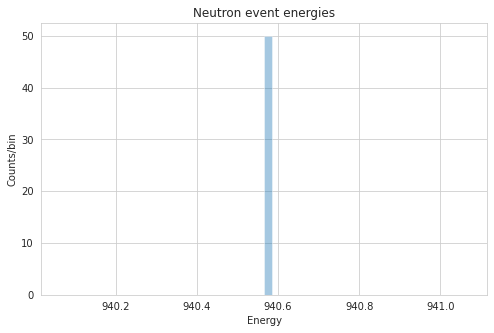

In [162]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 
sns.distplot(neutron_energies, rug = False, kde=True, axlabel ="Energy", norm_hist=False)
plt.title("Neutron event energies")
plt.ylabel("Counts/bin")

In [166]:
print(neutron_energies[:10])
print(e_energies[:10])

[940.56537 940.56537 940.56537 940.56537 940.56537 940.56537 940.56537
 940.56537 940.56537 940.56537]
[9.703471, 6.893087, 6.392733, 15.772576, 4.0892606, 10.898928, 7.5624266, 15.9206085, 14.884148, 20.420986]
